In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import random

from queue import PriorityQueue
from torch.autograd import Variable
from PIL import Image
from IPython.display import display

# Usage: display(img)

In [2]:
data_path = './data'
dataset = {}

set_types = ['images_background', 'images_valid', 'images_test']
alpha_chars = {}
for set_type in set_types:
    alpha_chars[set_type] = set()
    dataset[set_type] = {}

for set_type in os.listdir(data_path):    
    print('Reading from {}'.format(set_type))
    set_path = os.path.join(data_path, set_type)
    for alpha_idx, alphabet in enumerate(os.listdir(set_path)):
        if alpha_idx > 10 and set_type == 'images_evaluation':
            new_set_type = 'images_test' # Test
        elif set_type == 'images_evaluation':
            new_set_type = 'images_valid' # Valid
        else:
            new_set_type = set_type # Train
        print(new_set_type)
        dataset[new_set_type][alphabet] = {}
        alphabet_path = os.path.join(set_path, alphabet)
        # print(alphabet)
        for _, character in enumerate(os.listdir(alphabet_path)):
            alpha_chars[new_set_type].update(['__'.join([alphabet, character])])
            dataset[new_set_type][alphabet][character] = []
            character_path = os.path.join(alphabet_path, character)
            for k, sample in enumerate(os.listdir(character_path)):
                img = Image.open(os.path.join(character_path, sample))
                dataset[new_set_type][alphabet][character] += [np.asarray(img, np.uint8)]
                img.close()

Reading from images_evaluation
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_valid
images_test
images_test
images_test
images_test
images_test
images_test
images_test
images_test
images_test
Reading from images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background
images_background


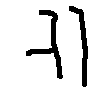

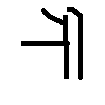

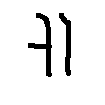

20
(105, 105)


In [3]:
display(Image.fromarray(dataset['images_background']['Korean']['character06'][0]*255))
display(Image.fromarray(dataset['images_background']['Korean']['character06'][5]*255))
display(Image.fromarray(dataset['images_background']['Korean']['character06'][15]*255))

print(len(dataset['images_background']['Korean']['character01']))
print(dataset['images_background']['Korean']['character01'][0].shape)

In [4]:
def get_drawers(set_type, alpha, char, diff=False, alpha2=None, char2=None):
    drawer1 = np.random.randint(len(dataset[set_type][alpha][char]))
    drawer2 = drawer1
    
    if not diff:
        while drawer2 == drawer1:
            drawer2 = np.random.randint(len(dataset[set_type][alpha][char]))
    else:
        while drawer2 == drawer1:
            drawer2 = np.random.randint(len(dataset[set_type][alpha2][char2]))
    assert drawer1 != drawer2
    
    return drawer1, drawer2

def get_random_dataset(set_type, set_size, shuffle_dataset=True):
    inputs = []
    labels = []
    for _ in range(set_size):
        same_alpha, same_char = random.sample(alpha_chars[set_type], 1)[0].split('__')
        drawer1, drawer2 = get_drawers(set_type, same_alpha, same_char)
        inputs.append([dataset[set_type][same_alpha][same_char][drawer1].flatten(), 
                           dataset[set_type][same_alpha][same_char][drawer2].flatten()])
        labels.append(1)

        diff1_alpha, diff1_char = random.sample(alpha_chars[set_type], 1)[0].split('__')
        diff2_alpha = diff1_alpha
        diff2_char = diff1_char
        while diff2_alpha == diff1_alpha and diff2_char == diff1_char:
            diff2_alpha, diff2_char = random.sample(alpha_chars[set_type], 1)[0].split('__')
        drawer1, drawer2 = get_drawers(set_type, diff1_alpha, diff1_char, True, diff2_alpha, diff2_char)
        inputs.append([dataset[set_type][diff1_alpha][diff1_char][drawer1].flatten(), 
                           dataset[set_type][diff2_alpha][diff2_char][drawer2].flatten()])
        labels.append(0)
        
    # Shuffle dataset
    combined = list(zip(inputs, labels))
    random.shuffle(combined)
    
    return zip(*combined)

train_inputs, train_labels = get_random_dataset('images_background', 15000)
valid_inputs, valid_labels = get_random_dataset('images_valid', 5000)
test_inputs, test_labels = get_random_dataset('images_test', 5000)

print(np.array(train_inputs).shape, np.array(train_labels).shape)
print(np.array(valid_inputs).shape, np.array(valid_labels).shape)
print(np.array(test_inputs).shape, np.array(test_labels).shape)

(30000, 2, 11025) (30000,)
(10000, 2, 11025) (10000,)
(10000, 2, 11025) (10000,)


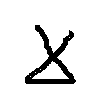

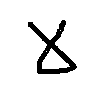

1
Kannada
dict_keys(['character01', 'character19', 'character40', 'character09', 'character37', 'character39', 'character11', 'character34', 'character33', 'character13', 'character35', 'character38', 'character25', 'character04', 'character23', 'character30', 'character22', 'character02', 'character21', 'character15', 'character29', 'character12', 'character27', 'character07', 'character16', 'character31', 'character06', 'character10', 'character41', 'character24', 'character20', 'character08', 'character18', 'character14', 'character32', 'character28', 'character26', 'character17', 'character36', 'character03', 'character05'])
6 15
character01
20
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [5]:
sample_idx = np.random.randint(len(train_inputs))
display(Image.fromarray(np.reshape(train_inputs[sample_idx][0]*255, (105, 105))))
display(Image.fromarray(np.reshape(train_inputs[sample_idx][1]*255, (105, 105))))
print(train_labels[sample_idx])

for alpha, char_set in dataset['images_test'].items():
    print(alpha)
    print(char_set.keys())
    
    drawer1 = np.random.randint(20)
    drawer2 = drawer1
    while drawer2 == drawer1:
        drawer2 = np.random.randint(20)
    
    print(drawer1, drawer2)
    
    for char, samples in char_set.items():
        print(char)
        print(len(samples))
        # Get two outputs per samples
        print(samples[0])
        break
    
    break
    # Find most similar outputs

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, padding=0),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU())
        self.fc = nn.Linear(9216, 4096)
        self.distance_fc = nn.Linear(4096, 1)
    
    def siamese_net(self, inputs):
        inputs = inputs.view(-1, 1, 105, 105)
        out = self.layer1(inputs)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        fc = self.fc(out.view(out.size(0), -1))
        return fc
    
    def distance_layer(self, input1, input2):
        return F.sigmoid(self.distance_fc(torch.abs(input1 - input2))).squeeze(1)
    
    def forward(self, x1, x2):
        
        out1 = self.siamese_net(x1)
        out2 = self.siamese_net(x2)
        # print(out1.size())
        # print(out2.size())
        distance = self.distance_layer(out1, out2)
        # print(distance.size())
        
        return distance, out1, out2

In [ ]:
cnn = CNN().cuda()

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-1, momentum=0.5)

num_epochs = 5
batch_size = 128

# Train the Model
for epoch in range(num_epochs):
    cnn.train(True)
    '''
    for train_idx in range(0, len(train_inputs), batch_size):
        batch_inputs = train_inputs[train_idx:train_idx+batch_size]
        batch_input1 = [b[0] for b in batch_inputs]
        batch_input2 = [b[1] for b in batch_inputs]
        batch_labels = train_labels[train_idx:train_idx+batch_size]
        # print(np.array(batch_input1).shape)
        # print(np.array(batch_input2).shape)
        # print(np.array(batch_label).shape)
        input1 = Variable(torch.Tensor(np.array(batch_input1).astype(np.float32))).cuda(0)
        input2 = Variable(torch.Tensor(np.array(batch_input2).astype(np.float32))).cuda(0)
        labels = Variable(torch.Tensor(np.array(batch_labels).astype(np.float32))).cuda(0)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs, _, _ = cnn(input1, input2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (train_idx) % (batch_size * 30) == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, train_idx+1, len(train_inputs), loss.data[0]))
    
    # Validation
    cnt = 0
    acc = 0.
    losses = 0.
    cnn.train(False)
    for valid_idx in range(0, len(valid_inputs), batch_size):
        batch_inputs = valid_inputs[valid_idx:valid_idx+batch_size]
        batch_input1 = [b[0] for b in batch_inputs]
        batch_input2 = [b[1] for b in batch_inputs]
        batch_labels = valid_labels[valid_idx:valid_idx+batch_size]
        # print(np.array(batch_input1).shape)
        # print(np.array(batch_input2).shape)
        # print(np.array(batch_label).shape)
        input1 = Variable(torch.Tensor(np.array(batch_input1).astype(np.float32))).cuda(0)
        input2 = Variable(torch.Tensor(np.array(batch_input2).astype(np.float32))).cuda(0)
        labels = Variable(torch.Tensor(np.array(batch_labels).astype(np.float32))).cuda(0)

        # Forward + Backward + Optimize
        outputs, _, _ = cnn(input1, input2)
        loss = criterion(outputs, labels)
        
        outputs = [int(k > 0.5) for k in outputs.data.tolist()]
        acc += sum([o == l for o, l in zip(outputs, batch_labels)])/input1.size(0)
        losses += loss.data[0]
        cnt += 1
        
    print('Validation acc:{} loss: {}'.format(acc/cnt, losses/cnt))
    '''
    
    for alpha, char_set in dataset['images_test'].items():
        # Select two drawers
        drawer1 = np.random.randint(20)
        drawer2 = drawer1
        while drawer2 == drawer1:
            drawer2 = np.random.randint(20)
        
        sim_dict = {}
        for char1, samples1 in char_set.items():
            sim_dict[char1] = PriorityQueue()
            for char2, samples2 in char_set.items():
                input1 = Variable(torch.Tensor(np.array([samples1[drawer1]]).astype(np.float32))).cuda(0)
                input2 = Variable(torch.Tensor(np.array([samples2[drawer2]]).astype(np.float32))).cuda(0)
                distance, _, _ = cnn(input1, input2)
                sim_dict[char1].put((-distance.data[0], char2))
            
            score, predicted = sim_dict[char1].get()
            if alpha == 'Atemayar_Qelisayer':
                print(alpha, char1, predicted, -score)
            # Get two outputs per samples
            # print(samples[0])


Atemayar_Qelisayer character01 character10 0.49790915846824646
Atemayar_Qelisayer character19 character10 0.49783775210380554
Atemayar_Qelisayer character09 character03 0.4975956082344055
Atemayar_Qelisayer character11 character10 0.497103750705719
Atemayar_Qelisayer character13 character16 0.49747857451438904
Atemayar_Qelisayer character23 character21 0.49777549505233765
Atemayar_Qelisayer character22 character21 0.49730628728866577
Atemayar_Qelisayer character02 character10 0.4980393350124359
Atemayar_Qelisayer character21 character19 0.4969276487827301
Atemayar_Qelisayer character15 character26 0.4974838197231293
Atemayar_Qelisayer character12 character22 0.49794626235961914
Atemayar_Qelisayer character07 character26 0.4977181851863861
Atemayar_Qelisayer character16 character16 0.4969179928302765
Atemayar_Qelisayer character06 character10 0.49733033776283264
Atemayar_Qelisayer character10 character11 0.4977189004421234
Atemayar_Qelisayer character03 character22 0.49790099263191223
A